In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
charts = pd.read_csv('2019_top_100.csv')

In [32]:
charts

,artist,song,label,position,start_date,end_date
0,Capital Bra,Benzema,Universal Domestic Urban,1,28.12.2018,03.01.2019
1,Mariah Carey,All I Want For Christmas Is You,SME - Columbia,2,28.12.2018,03.01.2019
2,Wham!,Last Christmas,SME - Epic,3,28.12.2018,03.01.2019
3,Ava Max,Sweet But Psycho,Atlantic,4,28.12.2018,03.01.2019
4,Chris Rea,Driving Home For Christmas,Warner Music International,5,28.12.2018,03.01.2019
...,...,...,...,...,...,...
5295,Michael Bublé,Santa Claus Is Coming To Town,Reprise,96,27.12.2019,02.01.2020
5296,Apache 207,Sex mit dir,SME - Two Sides,97,27.12.2019,02.01.2020
5297,"The Cratez, Luciano & Kontra K",Himmel grau,SME - RBK,98,27.12.2019,02.01.2020
5298,The Kingdom Choir feat. Camélia Jordana & Namika,Holidays Are Coming,SME - Sony Music,99,27.12.2019,02.01.2020


In [33]:
charts['start_date']= pd.to_datetime(charts['start_date'], format='%d.%m.%Y')
charts['end_date']= pd.to_datetime(charts['end_date'], format='%d.%m.%Y')

In [34]:
charts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5300 entries, 0 to 5299
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   artist      5300 non-null   object        
 1   song        5300 non-null   object        
 2   label       5297 non-null   object        
 3   position    5300 non-null   int64         
 4   start_date  5300 non-null   datetime64[ns]
 5   end_date    5300 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 248.6+ KB


In [35]:
import datetime as dt

In [36]:
charts['week'] = charts['start_date'].dt.week

In [66]:
tracks = test.song.unique()

peak_positions = charts.groupby(['song'])['position'].min()

for track in tracks:
    charts.loc[test['song'] == track, 'peak'] = peak_positions[track]

In [67]:
charts.head()

,artist,song,label,position,start_date,end_date,week,peak
0,Capital Bra,Benzema,Universal Domestic Urban,1,2018-12-28,2019-01-03,52,1.0
1,Mariah Carey,All I Want For Christmas Is You,SME - Columbia,2,2018-12-28,2019-01-03,52,1.0
2,Wham!,Last Christmas,SME - Epic,3,2018-12-28,2019-01-03,52,2.0
3,Ava Max,Sweet But Psycho,Atlantic,4,2018-12-28,2019-01-03,52,1.0
4,Chris Rea,Driving Home For Christmas,Warner Music International,5,2018-12-28,2019-01-03,52,5.0


In [68]:
charts.columns

Index(['artist', 'song', 'label', 'position', 'start_date', 'end_date', 'week',
       'peak'],
      dtype='object')

In [69]:
counts = charts['artist'].value_counts().rename_axis('artist').reset_index(name='counts')
counts

,artist,counts
0,Apache 207,125
1,Capital Bra,119
2,Mero,93
3,Shindy,81
4,Billie Eilish,79
...,...,...
514,Fler feat. Farid Bang,1
515,18 Karat feat. Gzuz,1
516,LX & Maxwell feat. Gzuz,1
517,KC Rebell feat. Ufo361,1


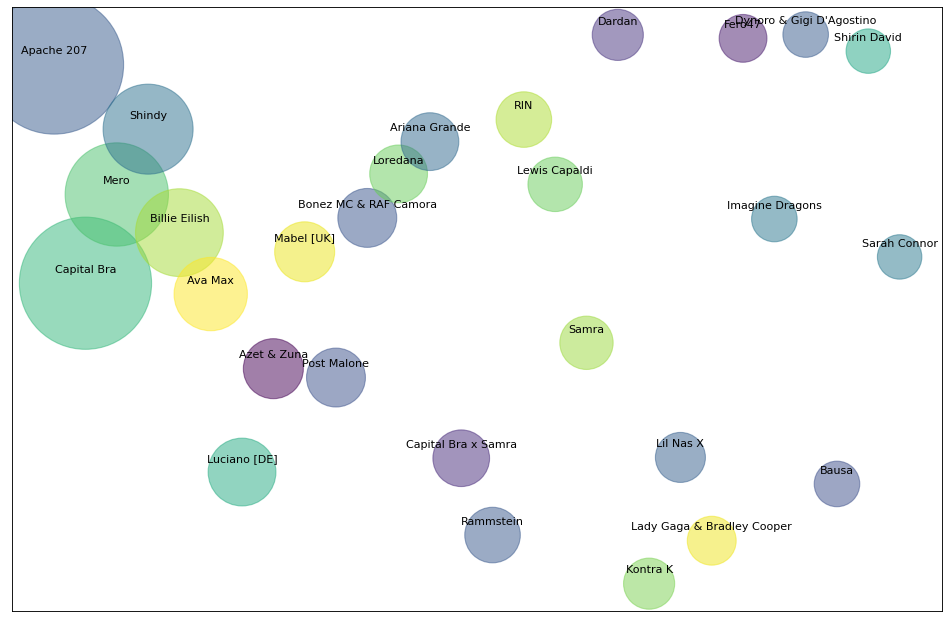

In [70]:
plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

top_artists = counts[counts['counts'] >= 40]

x = top_artists['artist']
y = np.random.rand(len(x))
#y_shuffled = np.random.shuffle(y)
colors = np.random.rand(len(x))
plt.scatter(x, y,
         marker='o', s=top_artists['counts']**2, alpha=.5, c=colors)

for i,j in zip(x,y):
    label = i
    
    # this method is called for each point
    plt.annotate(label, # this is the text
                 (i,j), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.xticks([], [])
plt.yticks([], [])

plt.show()

In [71]:
def info_artist(artist_name):
    df = charts[charts['artist'] == artist_name].sort_values(by='start_date').copy()
    tracks = df.song.unique()
    plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

    for track in tracks:
        x = df[df['song'] == track]['start_date']
        y = df[df['song'] == track]['position']
        plt.scatter(x, y,
                 marker='o', s=1000-y*10, alpha=.5,
                 label=track)

    plt.yticks(np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))

    plt.legend(numpoints=1)

    ax = plt.gca()
    ax.invert_yaxis()

    plt.show()

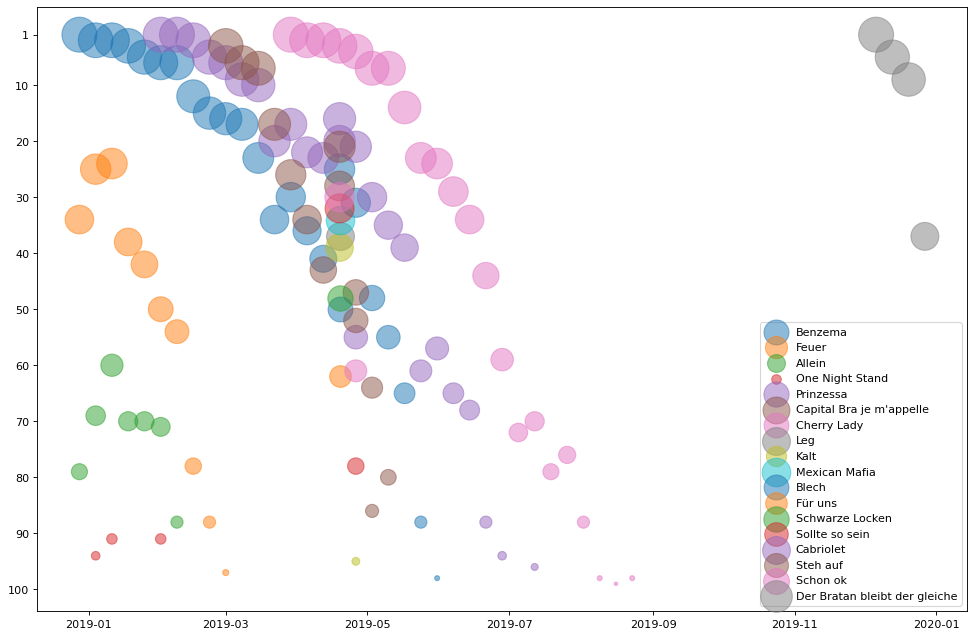

In [72]:
info_artist('Capital Bra')

In [43]:

repl = [' feat. ', ' x ', ' & ', ' , ']

test = charts['artist'].copy()

for r in repl:
    test = test.str.replace(r, '/').astype(str)
#    test = test.str.split('/')
    
test.value_counts()

Apache 207                     125
Capital Bra                    119
Mero                            93
Shindy                          81
Billie Eilish                   79
                              ... 
Ghetto Phénomène/RAF Camora      1
Rooz/Olexesh                     1
Kianush/Jamule                   1
Mois/Sun Diego                   1
Tobee                            1
Name: artist, Length: 514, dtype: int64

In [65]:
# find artists with most no.1 singles

